In [1]:
import numpy as np
import pandas as pd

In [2]:
# load data
df_class = pd.read_csv(r'C:\Users\fyang\CCS-Prediction-Publish\Data\SuperClass_modeling_data.csv',index_col=None)

In [3]:
df_class.head(5)

,name,formula,CID,SMILES,adduct,CCS,Super.Class,Class,Subclass,Source
0,Meso-tartrate,C4H606,447315,[C@@H]([C@@H](C(=O)O)O)(C(=O)O)O,[M-H],118.4,Organic acids and derivatives,Hydroxy acids and derivatives,Beta hydroxy acids and derivatives,20190304JAP_CCSdatabase_final.csv
1,L-(+)-Tartartic Acid,C4H6O6,444305,[C@@H]([C@H](C(=O)O)O)(C(=O)O)O,[M-H],118.3,Organic acids and derivatives,Hydroxy acids and derivatives,Beta hydroxy acids and derivatives,20190304JAP_CCSdatabase_final.csv
2,trans-Aconitic Acid,C6H6O6,444212,C(/C(=C\C(=O)O)/C(=O)O)C(=O)O,[M-H],131.4,Organic acids and derivatives,Carboxylic acids and derivatives,Tricarboxylic acids and derivatives,20190304JAP_CCSdatabase_final.csv
3,2-Keto-3-deoxy-D-gluconic Acid Lithium Salt,C6H11O6,161227,C([C@@H]([C@@H](CO)O)O)C(=O)C(=O)O,[M-H],133.9,Organic acids and derivatives,Keto acids and derivatives,Medium-chain keto acids and derivatives,20190304JAP_CCSdatabase_final.csv
4,3-Deoxy-2-keto-6-phosphogluconic Acid Lithium ...,C6H11O9P,3080745,C([C@@H]([C@@H](COP(=O)(O)O)O)O)C(=O)C(=O)O,[M-H],143.6,Organic acids and derivatives,Organic acids and derivatives,Medium-chain keto acids and derivatives,20190304JAP_CCSdatabase_final.csv


# Calculate fingerprints

In [4]:
from rdkit import Chem
from rdkit.Chem import PandasTools

# get fingerprints
def get_FPs(df):
    
    # from SMILES to mol
    PandasTools.AddMoleculeColumnToFrame(df,
                                         'SMILES','Molecules',
                                         includeFingerprints = True)
    df.dropna(subset = ['Molecules'],inplace = True)
    df = df.reset_index()
    # from mol to FPs
    df['FPs'] =[Chem.RDKFingerprint(mol, fpSize = 1024) for mol in df.Molecules]
    
    return df

In [5]:
df_class= get_FPs(df_class)

# Tuning

In [6]:
# Random forest classifier modeling
from sklearn.model_selection import train_test_split

X_SC = df_class['FPs'].tolist()
y_SC = df_class['Super.Class'].values

X_SC_train, X_SC_test, y_SC_train, y_SC_test = train_test_split(X_SC, y_SC, 
                                                                train_size = 0.8, 
                                                                test_size=0.2, 
                                                                random_state=101,
                                                                stratify=y_SC)

print('X_SC_train: {}'.format(np.shape(X_SC_train)))
print('y_SC_train: {}'.format(np.shape(y_SC_train)))
print('X_SC_test: {}'.format(np.shape(X_SC_test)))
print('y_SC_test: {}'.format(np.shape(y_SC_test)))

X_SC_train: (836, 1024)
y_SC_train: (836,)
X_SC_test: (210, 1024)
y_SC_test: (210,)


In [7]:
# check training data
unique, counts = np.unique(y_SC_train, return_counts=True)
print (np.asarray((unique, counts)).T)

[['Benzenoids' 181]
 ['Lipids and lipid-like molecules' 189]
 ['Organic acids and derivatives' 184]
 ['Organic oxygen compounds' 142]
 ['Organoheterocyclic compounds' 140]]


In [8]:
# check test data
unique_test, counts_test = np.unique(y_SC_test, return_counts=True)
print (np.asarray((unique_test, counts_test)).T)

[['Benzenoids' 46]
 ['Lipids and lipid-like molecules' 47]
 ['Organic acids and derivatives' 46]
 ['Organic oxygen compounds' 36]
 ['Organoheterocyclic compounds' 35]]


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [10]:
# set parameters for tuning

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 200, num = 5)]
# Quality of a split
criterion = ['gini']
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [None]
# Minimum number of samples required to split a node
# min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 5, num =3)]
# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(start = 5, stop = 15, num =5)]
# Use out-of-bag samples to estimate the generalization score. 
oob_score = [True]

In [11]:
# Creat the param grid
param_grid = {'n_estimators': n_estimators,
              #'criterion': criterion,
              #'max_features': max_features,
              #'max_depth': max_depth,
              #'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
             # 'oob_score': oob_score
               }
# Define model type
rfc_Model = RandomForestClassifier(oob_score = [True])

In [12]:
rfc_Grid = GridSearchCV(estimator = rfc_Model, 
                       param_grid = param_grid, 
                       cv = 5, 
                       verbose=2, 
                       n_jobs = 3,
                       return_train_score = True
                       )


rfc_Grid.fit(X_SC_train, y_SC_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(oob_score=[True]), n_jobs=3,
             param_grid={'min_samples_leaf': [5, 7, 10, 12, 15],
                         'n_estimators': [100, 125, 150, 175, 200]},
             return_train_score=True, verbose=2)

# Model evalutaions

In [109]:
# Optimized method 
print(rfc_Grid.best_params_)
print (f'Train Accuracy - : {rfc_Grid.score(X_SC_train,y_SC_train):.3f}')
print (f'Test Accuracy - : {rfc_Grid.score(X_SC_test,y_SC_test):.3f}')

{'min_samples_leaf': 5, 'n_estimators': 125}
Train Accuracy - : 0.937
Test Accuracy - : 0.871


In [102]:
# F1 Scores
from sklearn.metrics import f1_score, make_scorer
labels = rfc_Grid.classes_
f1 = make_scorer(f1_score, average = None, labels = labels)

pred=rfc_Grid.predict(X_SC_test)

f1_score = f1_score(y_SC_test, pred, average= None,
             labels = labels)
f1_score

array([0.90526316, 0.90909091, 0.84782609, 0.86111111, 0.82191781])

In [110]:
# save the model
import joblib
filename = 'classPred.joblib'
joblib.dump(rfc_Grid, filename)

['classPred.joblib']

In [16]:
import matplotlib.pyplot as plt
# Plot results

def plot_search_results(grid):

    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='-', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

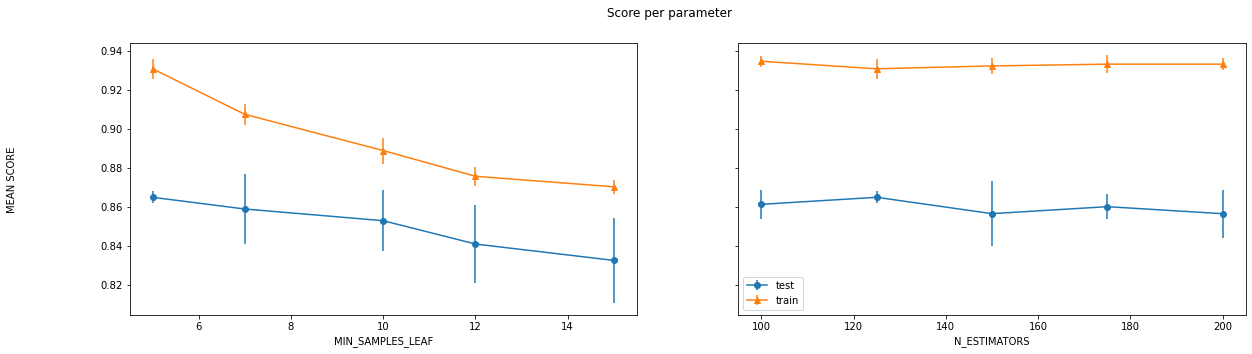

In [17]:
plot_search_results(rfc_Grid)

##  visualise Random forest trees

In [18]:

rfc_opt = rfc_Grid.best_estimator_
labels = rfc_Grid.classes_
from sklearn.tree import export_graphviz

for index in range(0, 5):
    export_graphviz(rfc_opt[index], out_file='tree'+str(index)+'.dot', 
                #feature_names = fn,
                class_names = labels,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

## Feature importances

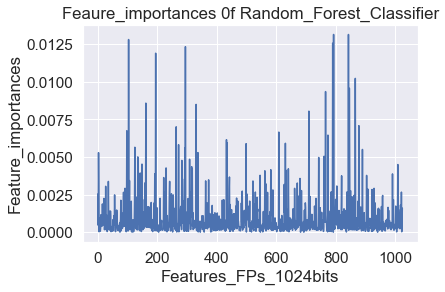

In [104]:
# Calculate feature importances
importances = rfc_opt.feature_importances_
list_feature = [i for i in range(1024)]
plt.plot(importances)
plt.title('Feaure_importances 0f Random_Forest_Classifier')
plt.xlabel('Features_FPs_1024bits')
plt.ylabel('Feature_importances')
plt.show()

In [21]:
plt.savefig('SC_FeatureImportances.png',bbox_inches='tight',dpi = 100)

<Figure size 432x288 with 0 Axes>

In [22]:
# investigate the top 5 importance features
ind = np.argpartition(importances,-5)[-5:] 
print(ind)
print(importances[ind])

[842 124 103 865 294]
[0.01060882 0.01097353 0.01262759 0.01099805 0.01505963]


In [135]:
# investigate the top 5 importance features
ind = np.argpartition(importances,-5)[-5:] 
print(ind)
print(importances[ind])

[294 789 103 842 792]
[0.01233671 0.01257065 0.01281291 0.01314848 0.01315018]


## visualise relevant features

In [27]:
from rdkit.Chem import Draw
from rdkit import Chem
# get feature examples
def get_svgs(mols,ind):
    rdkbi = {}
    rdkfp = Chem.RDKFingerprint(mols, 2, fpSize = 1024, bitInfo=rdkbi)
    svg = Draw.DrawRDKitBit(mols, ind, rdkbi, useSVG=True)
    return(svg)

In [39]:
#for i in ind:
import random
def random_indices(feature):
    indices = []
    while len(indices) <6:
        j = random.randint(0,1046)
        if df_class['FPs'][j][feature] == 1:
            indices.append(j)
    return indices

In [40]:
indices865 = random_indices(865)
indices865

[112, 756, 530, 314, 690, 862]

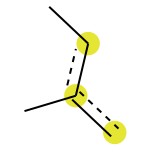

In [41]:
from IPython.core.display import display
random_mols = random.choice(indices865)
mols = df_class['Molecules'] [random_mols]
svg = get_svgs(mols, 865)
display(svg)

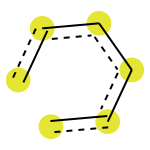

In [42]:
random_mols = random.choice(indices865)
mols = df_class['Molecules'] [random_mols]
svg = get_svgs(mols, 865)
display(svg)

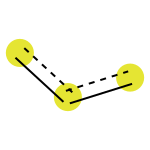

In [43]:
indices294 = random_indices(294)
random_mols = random.choice(indices294)
mols = df_class['Molecules'] [random_mols]
svg = get_svgs(mols, 294)
display(svg)

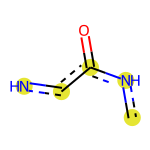

In [52]:
indices103 = random_indices(103)
random_mols = random.choice(indices103)
mols = df_class['Molecules'] [random_mols]
svg = get_svgs(mols, 103)
display(svg)

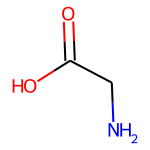

In [53]:
indices124 = random_indices(124)
random_mols = random.choice(indices124)
mols = df_class['Molecules'] [random_mols]
svg = get_svgs(mols, 124)
display(svg)

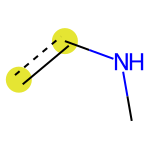

In [55]:
indices124 = random_indices(124)
random_mols = random.choice(indices124)
mols = df_class['Molecules'] [random_mols]
svg = get_svgs(mols, 124)
display(svg)

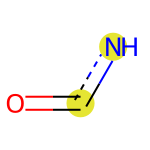

In [62]:
indices842 = random_indices(842)
random_mols = random.choice(indices842)
mols = df_class['Molecules'] [random_mols]
svg = get_svgs(mols, 842)
display(svg)

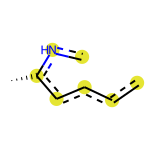

In [84]:
indices842 = random_indices(842)
random_mols = random.choice(indices842)
mols = df_class['Molecules'] [random_mols]
svg = get_svgs(mols, 842)
display(svg)

## Confusion Matrix

In [106]:
#Evaluation confusion matrix
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
matrix = confusion_matrix(y_SC_test, pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

In [107]:
matrix

array([[0.93478261, 0.        , 0.        , 0.        , 0.06521739],
       [0.04444444, 0.88888889, 0.04444444, 0.02222222, 0.        ],
       [0.        , 0.04166667, 0.8125    , 0.0625    , 0.08333333],
       [0.05555556, 0.        , 0.05555556, 0.86111111, 0.02777778],
       [0.05714286, 0.02857143, 0.02857143, 0.02857143, 0.85714286]])

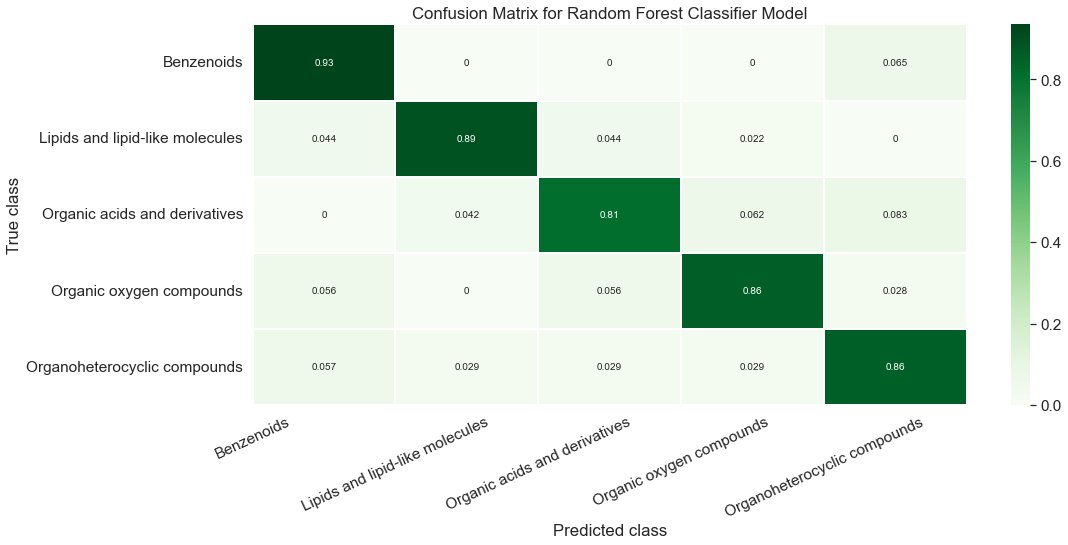

In [108]:
import seaborn as sns
# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
labels # SuperClass name

tick_marks = np.arange(len(labels))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, labels, rotation=25)
plt.yticks(tick_marks2, labels, rotation=0)
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.title('Confusion Matrix for Random Forest Classifier Model')
plt.show()

In [25]:
plt.savefig('Confusion Matrix.png',bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

## wrong prediction

In [85]:
df_test = df_class[df_class.FPs.isin(X_SC_test)]

C:\Users\fyang\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,index,name,formula,CID,SMILES,adduct,CCS,Super.Class,Class,Subclass,Source,Molecules,FPs,Super.ClassPred2
3,3,2-Keto-3-deoxy-D-gluconic Acid Lithium Salt,C6H11O6,161227,C([C@@H]([C@@H](CO)O)O)C(=O)C(=O)O,[M-H],133.900000,Organic acids and derivatives,Keto acids and derivatives,Medium-chain keto acids and derivatives,20190304JAP_CCSdatabase_final.csv,,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",Organic acids and derivatives
11,11,Cysteate,C3H7NO5S,12308854,C([C@@H](C(=O)O)N)S(=O)(=O)O.O,[M-H],123.300000,Organic acids and derivatives,Carboxylic acids and derivatives,"Amino acids, peptides, and analogues",20190304JAP_CCSdatabase_final.csv,,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",Organic acids and derivatives
19,19,Guanidinoacetate,C3H7N3O2,763,C(C(=O)O)N=C(N)N,[M+H],125.400000,Organic acids and derivatives,Carboxylic acids and derivatives,"Amino acids, peptides, and analogues",20190304JAP_CCSdatabase_final.csv,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Organic acids and derivatives
26,26,L-Arginine,C6H14N4O2,6322,C(C[C@@H](C(=O)O)N)CN=C(N)N,[M-H],137.200000,Organic acids and derivatives,Carboxylic acids and derivatives,"Amino acids, peptides, and analogues",20190304JAP_CCSdatabase_final.csv,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",Organic acids and derivatives
28,28,Selenocystamine,C4H12N2Se2,115119,C(C[Se][Se]CCN)N,[M+H],135.900000,Organic acids and derivatives,Carboxylic acids and derivatives,"Amino acids, peptides, and analogues",20190304JAP_CCSdatabase_final.csv,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Organic acids and derivatives
29,29,Oxoglutarate,C5H6O5,31040,C(CC(=O)[O-])C(=O)C(=O)[O-].[Na+].[Na+],[M-H],121.100000,Organic acids and derivatives,Keto acids and derivatives,Gamma-keto acids and derivatives,20190304JAP_CCSdatabase_final.csv,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Organic acids and derivatives
35,35,5-Aminolevulinate,C5H9NO3,137,C(CC(=O)O)C(=O)CN,[M+H],130.700000,Organic acids and derivatives,Carboxylic acids and derivatives,"Amino acids, peptides, and analogues",20190304JAP_CCSdatabase_final.csv,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Organic acids and derivatives
49,49,L-Cystathionine,C7H14N2O4S,439258,C(CSC[C@@H](C(=O)O)N)[C@@H](C(=O)O)N,[M-H],142.100000,Organic acids and derivatives,Carboxylic acids and derivatives,"Amino acids, peptides, and analogues",20190304JAP_CCSdatabase_final.csv,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",Organic acids and derivatives
57,57,(S)-Adenosyl-L-methionine,C15H22N6O5S,34755,C[S+](CC[C@@H](C(=O)[O-])N)C[C@@H]1[C@H]([C@H]...,[M+H],185.600000,Organic acids and derivatives,Carboxylic acids and derivatives,"Amino acids, peptides, and analogues",20190304JAP_CCSdatabase_final.csv,,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, ...",Organoheterocyclic compounds
59,59,Phosphoenol Pyruvate Monopotassium Salt,C3H4KO6P,77950,C=C(C(=O)O)OP(=O)(O)[O-].[K+],[M-H],163.700000,Organic acids and derivatives,Organic phosphonic acids and derivatives,Phosphate esters,20190304JAP_CCSdatabase_final.csv,,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...",Organic acids and derivatives

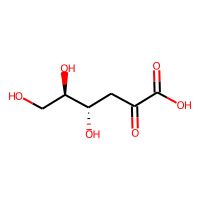
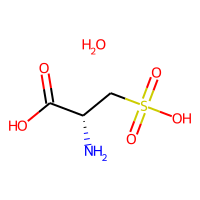
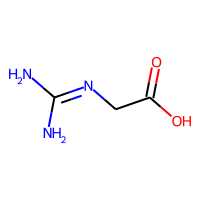
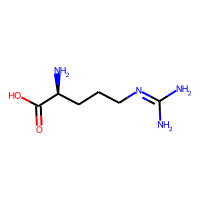
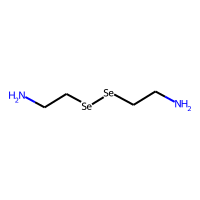
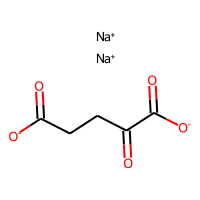
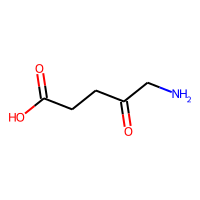
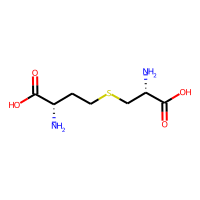
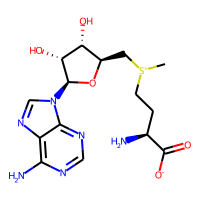
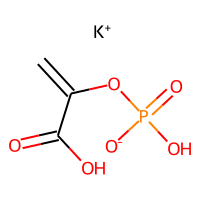
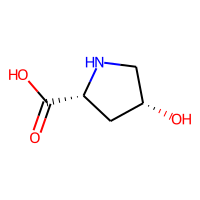
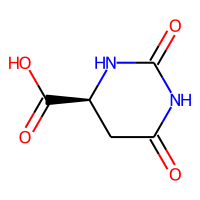
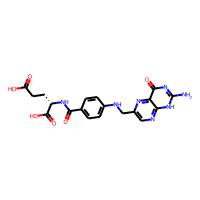
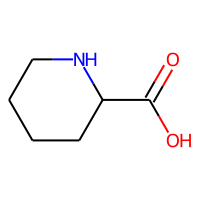
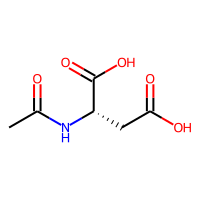
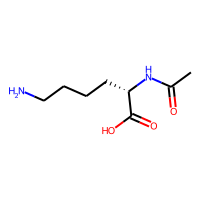
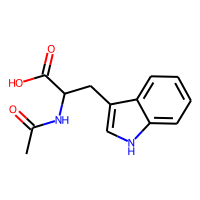
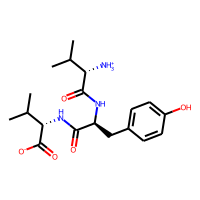
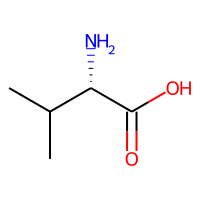
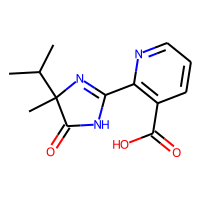
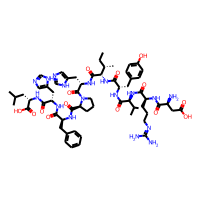
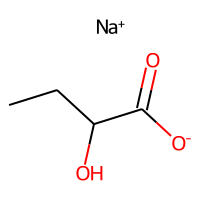
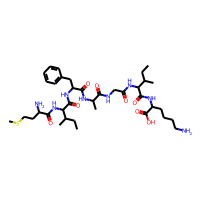
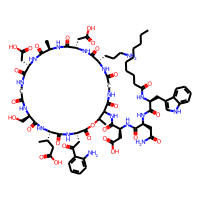
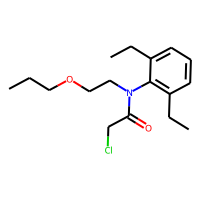
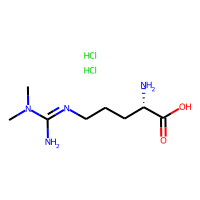
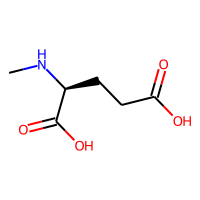
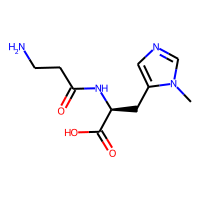
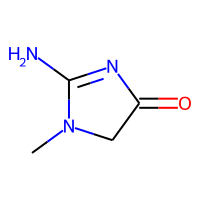
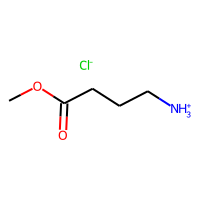
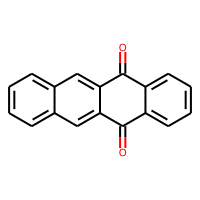
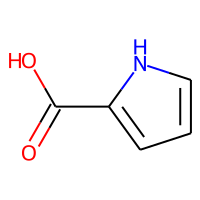
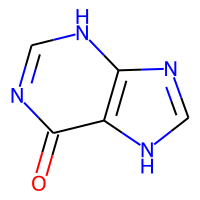
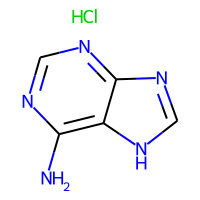
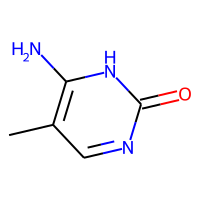
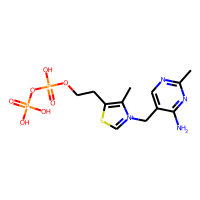
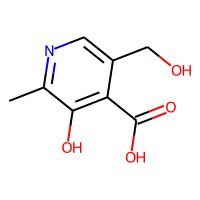
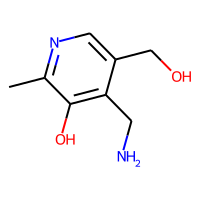
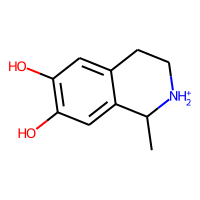
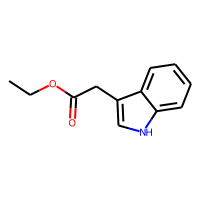
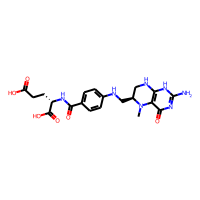
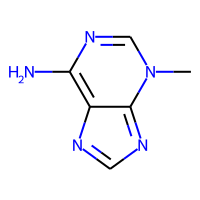
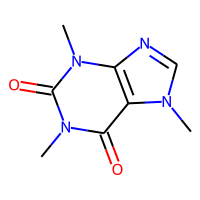
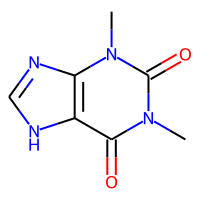
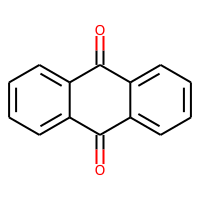
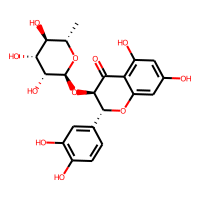
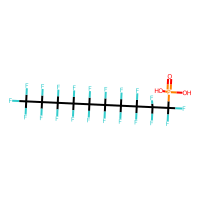
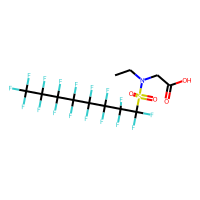
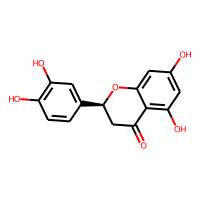
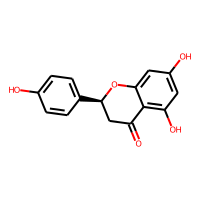
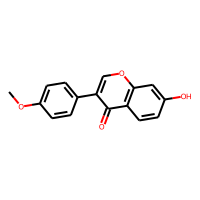
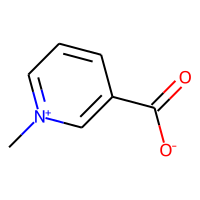
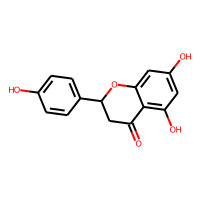
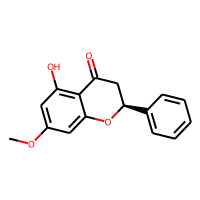
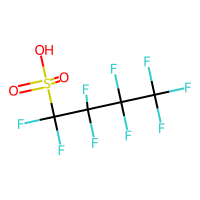
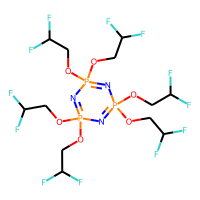
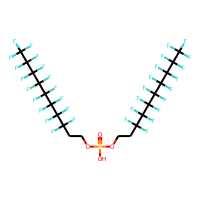
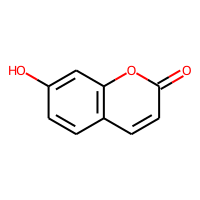
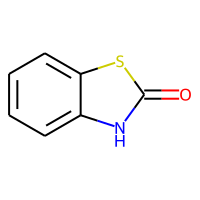
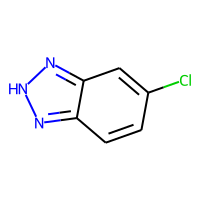

In [87]:
df_test['Super.ClassPred2'] = rfc_Grid.predict(df_test['FPs'].tolist())
df_test

In [88]:
# Compare predicted to defined class
df_test['comparison_column'] = np.where(df_test["Super.Class"] == df_test['Super.ClassPred2'], 
                                           True, False)

C:\Users\fyang\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,index,name,formula,CID,SMILES,adduct,CCS,Super.Class,Class,Subclass,Source,Molecules,FPs,Super.ClassPred2,comparison_column
57,57,(S)-Adenosyl-L-methionine,C15H22N6O5S,34755,C[S+](CC[C@@H](C(=O)[O-])N)C[C@@H]1[C@H]([C@H]...,[M+H],185.600000,Organic acids and derivatives,Carboxylic acids and derivatives,"Amino acids, peptides, and analogues",20190304JAP_CCSdatabase_final.csv,,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, ...",Organoheterocyclic compounds,False
70,70,Folate,C19H19N7O6,6037,C1=CC(=CC=C1C(=O)N[C@@H](CCC(=O)O)C(=O)O)NCC2=...,[M-H],192.100000,Organic acids and derivatives,Carboxylic acids and derivatives,"Amino acids, peptides, and analogues",20190304JAP_CCSdatabase_final.csv,,"[1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, ...",Organoheterocyclic compounds,False
95,95,N-Acetyl-DL-tryptophan,C13H14N2O3,2002,CC(=O)NC(CC1=CNC2=CC=CC=C21)C(=O)O,[M-H],158.600000,Organic acids and derivatives,Carboxylic acids and derivatives,"Amino acids, peptides, and analogues",20190304JAP_CCSdatabase_final.csv,,"[1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, ...",Organoheterocyclic compounds,False
112,112,Imazapyr,C13H15N3O3,54738,CC(C)C1(C(=O)NC(=N1)C2=C(C=CC=N2)C(=O)O)C,[M-H],164.400000,Organic acids and derivatives,Carboxylic acids and derivatives,"Amino acids, peptides, and analogues",20190304JAP_CCSdatabase_final.csv,,"[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...",Organoheterocyclic compounds,False
129,129,Daptomycin,C72H101N17O26,16129629,CCCCCCCCCC(=O)N[C@@H](CC1=CNC2=CC=CC=C21)C(=O)...,[M+H],379.300000,Organic acids and derivatives,Peptidomimetics,Depsipeptides,20190304JAP_CCSdatabase_final.csv,,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",Organoheterocyclic compounds,False
131,131,3-Nitro-L-tyrosine,C9H10N2O5,91644,CCCOCCN(C1=C(C=CC=C1CC)CC)C(=O)CCl,[M-H],149.000000,Organic acids and derivatives,Carboxylic acids and derivatives,"Amino acids, peptides, and analogues",20190304JAP_CCSdatabase_final.csv,,"[0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...",Benzenoids,False
195,195,Adenosine 5' Monophosphate,C10H14N5O7P,6083,C1=NC(=C2C(=N1)N(C=N2)[C@H]3[C@@H]([C@@H]([C@H...,[M+H],173.326702,Organic acids and derivatives,Nucleotides,NaN,metabolitedata.csv,,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, ...",Organoheterocyclic compounds,False
232,232,"Bis(3,5,5-trimethylhexyl)phosphate",C18H39O4P,96179,CC(CCOP(=O)(O)OCCC(C)CC(C)(C)C)CC(C)(C)C,[M+H]+,202.090000,Organic acids and derivatives,Organophosphorus,NaN,UACCSCEC_ac1c00142_si_002_TS-5.csv,,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Organic oxygen compounds,False
233,233,tris(2-ethylhexyl)phosphate,C24H51O4P,6537,CCCCC(CC)COP(=O)(OCC(CC)CCCC)OCC(CC)CCCC,[M+H]+,219.150000,Organic acids and derivatives,Organophosphorus,NaN,UACCSCEC_ac1c00142_si_002_TS-5.csv,,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Organic oxygen compounds,False
239,239,2-ethylhexyl phenyl phosphate,C14H23O4P,15591291,CCCCC(CC)COP(=O)(O)OC1=CC=CC=C1,[M-H]-,170.460000,Organic acids and derivatives,NaN,NaN,UACCSCEC_ac1c00142_si_002_TS-5.csv,,"[0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",Benzenoids,False

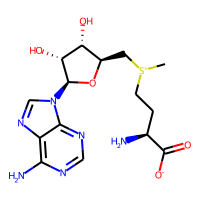
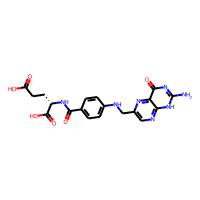
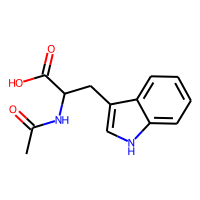
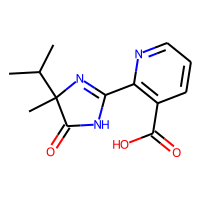
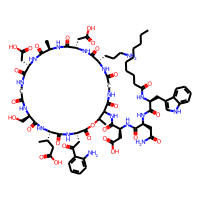
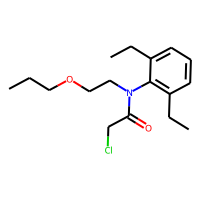
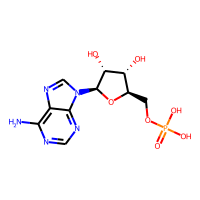
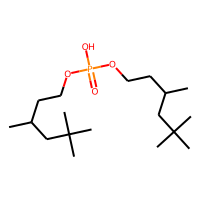
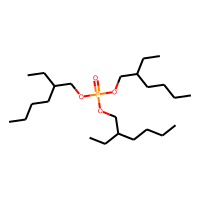
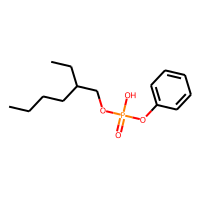
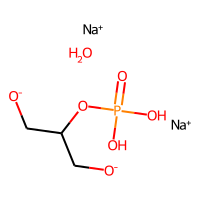
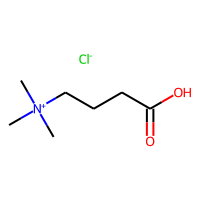
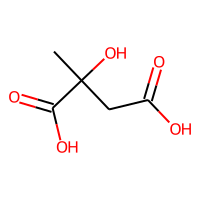
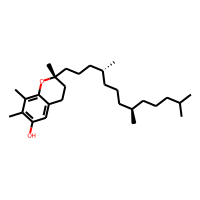
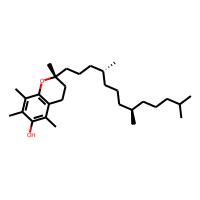
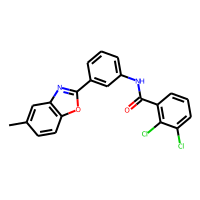
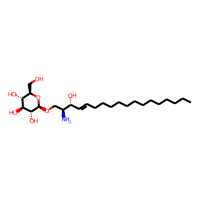
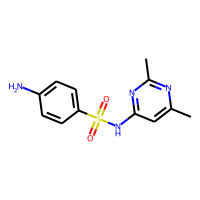
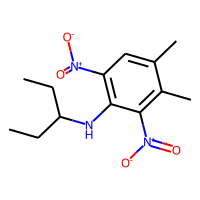
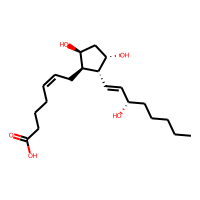
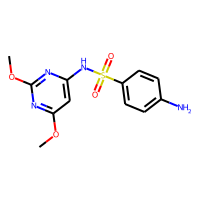
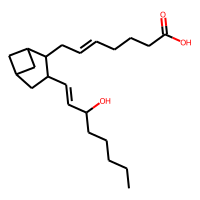
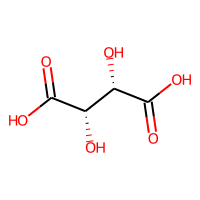
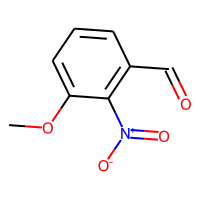
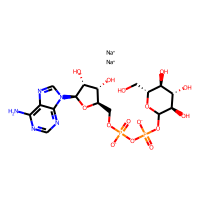
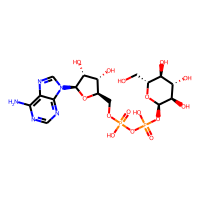
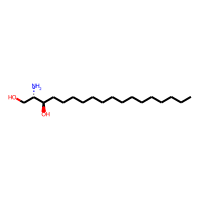
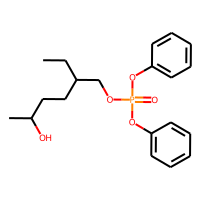
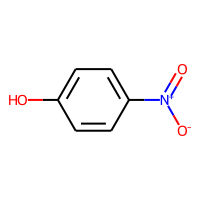
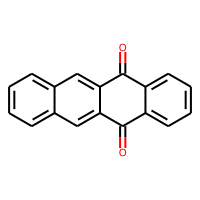
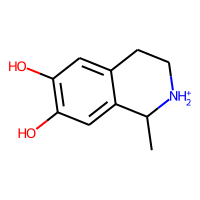
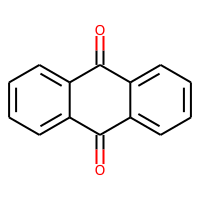
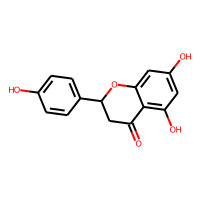
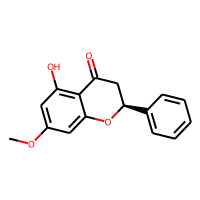
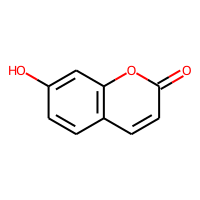

In [89]:
df_error = df_test.drop(df_test[df_test['comparison_column'] == True].index)
df_error

index  \
Super.Class                                   
Benzenoids                      594     594   
                                1021   1021   
                                1020   1020   
Lipids and lipid-like molecules 296     296   
                                241     241   
                                463     463   
Organic acids and derivatives   991     991   
                                4         4   
                                95       95   
Organic oxygen compounds        863     863   
                                752     752   
                                855     855   
Organoheterocyclic compounds    945     945   
                                1043   1043   
                                1042   1042   

                                                                                   name  \
Super.Class                                                                               
Benzenoids                      594                                    Sulfadimethoxine   
                                1021                                        Pinostrobin   
                                1020                                         Naringenin   
Lipids and lipid-like molecules 296                               Methyl Tetracosanoate   
                                241                                      D-(+)-Turanose   
                                463                                  Diisobutyl adipate   
Organic acids and derivatives   991     6:2 chlorinated polyfluorinated ether sulfonate   
                                4     3-Deoxy-2-keto-6-phosphogluconic Acid Lithium ...   
                                95                               N-Acetyl-DL-tryptophan   
Organic oxygen compounds        863                                2-Aminobenzothiazole   
                                752                   D-Glucose-6-phosphate Sodium Salt   
                                855                                         Sphinganine   
Organoheterocyclic compounds    945                                 3-Methyl-2-oxindole   
                                1043                              5-Chlorobenzotriazole   
                                1042                                      Benzotriazole   

                                          formula       CID  \
Super.Class                                                   
Benzenoids                      594   C12H14N4O4S      5323   
                                1021     C16H14O4     73201   
                                1020     C15H12O5       932   
Lipids and lipid-like molecules 296      C25H50O2    210602   
                                241     C12H22O11   5460935   
                                463      C14H26O4      8831   
Organic acids and derivatives   991   C8HClF16O4S  22568738   
                                4        C6H11O9P   3080745   
                                95     C13H14N2O3      2002   
Organic oxygen compounds        863       C7H6N2S      8706   
                                752      C6H13O9P     98867   
                                855     C18H39NO2     91486   
Organoheterocyclic compounds    945        C9H9NO    150923   
                                1043     C6H4ClN3     66760   
                                1042       C6H5N3      7220   

                                                                                 SMILES  \
Super.Class                                                                               
Benzenoids                      594         COC1=NC(=NC(=C1)NS(=O)(=O)C2=CC=C(C=C2)N)OC   
                                1021        COC1=CC(=C2C(=O)C[C@H](OC2=C1)C3=CC=CC=C3)O   
                                1020          C1C(OC2=CC(=CC(=C2C1=O)O)O)C3=CC=C(C=C3)O   
Lipids and lipid-like molecules 296                                CC(C)(CN)C1=CC=CC=C1   
                                241   C([C@@H]1[C@H]([C@@H]([C@H]([C@H](
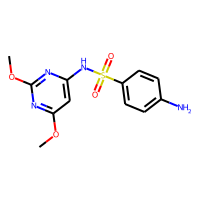
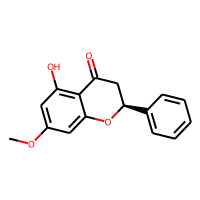
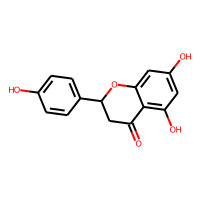
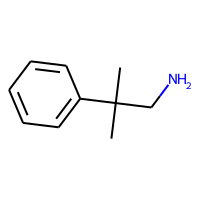
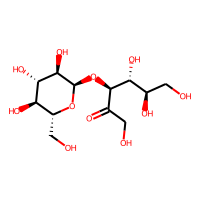
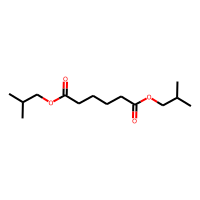
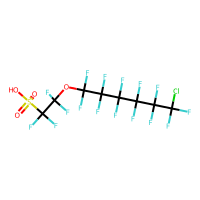
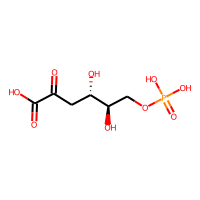
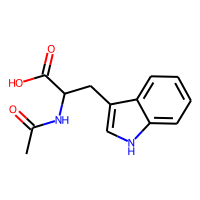
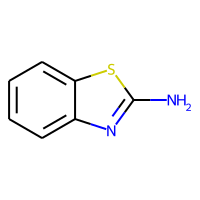
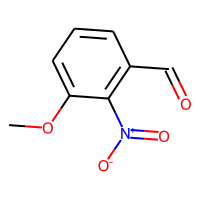
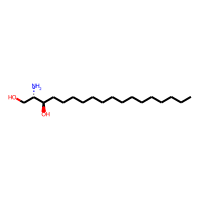
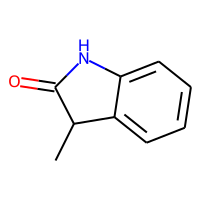
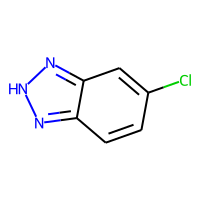
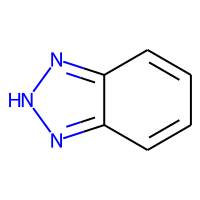

In [111]:
# randomly choose 3 confusion predicted chemicals from each class
df_randomError= df_error.groupby('Super.Class').apply(pd.DataFrame.sample, n = 3)
df_randomError

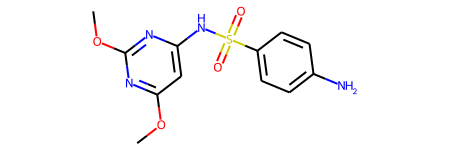

In [112]:
df_randomError.loc[df_randomError.index[0], 'Molecules']

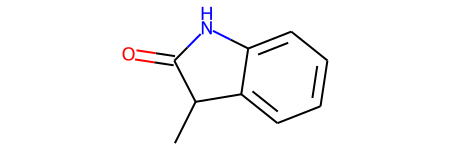

In [113]:
df_randomError.loc[df_randomError.index[-3], 'Molecules']

In [101]:
df_test.to_csv('ClassModel_test.csv',index=False)